In [267]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
import collections

In [2]:
# Model Metrics will be defined below

In [85]:
def confusion_matrix(y_prob: np.ndarray, y_true: np.ndarray, threshold = 0.5, verbose = False):
    '''
    Input - Y_pred : numpy array containing prediction probabilities between 0 to 1 
            Y_true : umpy array denoting true class (1/0)
            threshold: cutoff above which predicted class is 1 else 0
    Output - True Positive, False Positives, True Negatives, False Negatives, Precsion, .....
    '''
    total = y_true.shape[0]
    if total ==0 or total != y_prob.shape[0]:
        raise ValueError("Input array is empty or y_prob and y_true are not compatible")
    # Can also write check for contents of y_true and y_prob
    if sum(y_prob > 1) or sum(y_prob < 0):
        raise ValueError("Incorrect Entries present in y_pred")
        
    if sorted(list(collections.Counter(y_true).keys())) !=[0,1]:
        raise ValueError("Incorrect value in y_true, please ensure it contains only 1 or 0")
    if threshold >1 or threshold <0:
        raise ValueError ("Incorrect value for threshold, please enter a value between 0 to 1")
    
    y_pred = y_prob > threshold
    if verbose: print ("total: ", total, y_prob, y_true, y_pred, threshold)
    TP = np.where((y_true == 1) & (y_pred == 1))[0].shape[0]
    TN = np.where((y_true == 0) & (y_pred == 0))[0].shape[0]
    FP = np.where((y_true == 0) & (y_pred == 1))[0].shape[0]
    FN = np.where((y_true == 1) & (y_pred == 0))[0].shape[0]
    if verbose: print ("TP: ", TP)
    
    alpha = 1e-05
    precision =  TP/(TP+FP+alpha) # This alpha is required to handle cases where threshold is either 0 or 1
    recall = sensitivity = TPR = TP/(TP+FN+alpha)
    specificity = TN/(TN+FP+alpha)
    FPR = 1 - specificity
    accuracy = (TP+TN) / (total)
    
    return TP, TN, FP, FN, precision, recall, sensitivity, TPR, FPR, accuracy

    
y_prob = np.random.rand(100)
y_true =np.random.randint(0,2,100)
print (confusion_matrix(y_prob, y_true, verbose = False))   

(25, 29, 24, 22, 0.5102039775093923, 0.5319147804436637, 0.5319147804436637, 0.5319147804436637, 0.45283029191881286, 0.54)


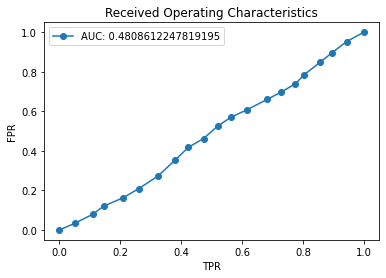

Manual & SK AUC val: 0.4808612247819195 0.4833496023427374
Diff in % b/w Manual & SK AUC:  0.15608040432452164


In [95]:
def roc_auc(y_prob, y_true, plot = True):
    '''
    Input - Y_pred : numpy array containing prediction probabilities between 0 to 1 
            Y_true : umpy array denoting true class (1/0)
            threshold: cutoff above which predicted class is 1 else 0
    # The thresholds can be 0.05 or 0.1 intervals or it can be sort(y_prob), it doesn't matter much.
    The difference between sklearn and my computation is < 0.5% ~ 50 bps which is very tiny 
    Output - Area under the curve
    '''
    thresholds = np.arange(0,1.05,0.05) 
    #thresholds = np.sort(y_prob)
    y_vals, x_vals = [], []
    for threshold in thresholds:
        custom_metrics = confusion_matrix(y_prob, y_true, threshold, verbose = False)
        TPR, FPR = custom_metrics[7:9]
        y_vals.append(TPR)
        x_vals.append(FPR)
    
    x_vals = x_vals[::-1] # Inversion is required because threshold = 0 is on top right 
    y_vals = y_vals[::-1]
    auc = 0 
    for i in range(1,len(thresholds)):
        dx = x_vals[i] - x_vals[i-1]
        y_avg = (y_vals[i] + y_vals[i-1])/2
        #print (i, dx, dy)
        auc += dx*y_avg
        
    sk_auc = metrics.roc_auc_score(y_true, y_prob)

    if plot:
        plt.plot(x_vals, y_vals, 'o-', label = "AUC: "+str(auc))
        plt.xlabel('TPR')
        plt.ylabel('FPR')
        plt.legend(loc = 'best')
        plt.title('Received Operating Characteristics')
        plt.show()
    return auc, sk_auc

auc, sk_auc = roc_auc(y_prob, y_true, plot = True)
print("Manual & SK AUC val:", auc, sk_auc)

diff = []
for _ in range(100):
    y_prob = np.random.rand(1000)
    y_true =np.random.randint(0,2,1000)
    auc, sk_auc = roc_auc(y_prob, y_true, plot = False)
    #print(auc, sk_auc)
    diff.append(abs(auc - sk_auc)*100/sk_auc)

print ("Diff in % b/w Manual & SK AUC: ", np.array(diff).mean())
    

In [281]:
### K-fold cross validation
class Kfold_custom:
    def __init__(self, k = 5, shuffle = False, verbose = False, seed = None):
        '''
        This class takes as input value of k, shuffle option and seed.
        It returns the indices of train and test for k folds. 
        The value of k should be minimum 2 and maximum length of input dataset.
        It works for binary & multiclass classifier & regressor
        '''
        self.k = k 
        if k <2:
            raise ValueError("The value of k should be atleast 2")
        self.shuffle = shuffle
        self.verbose = verbose
        self.seed = seed
    
    def split(self,X):
        num_entries = X.shape[0]
        indices = np.array(range(num_entries))
        if self.shuffle: 
            if self.seed:
                np.random.seed(self.seed)
            np.random.shuffle(indices)
        
        num_samples = (num_entries // self.k)*self.k
        if self.verbose: print ("num_samples: ", num_samples)
        indices_to_split, indices_left = indices[:num_samples], indices[num_samples:]
        
        all_splits = np.split(indices_to_split, self.k)
        
        all_splits_full = []
        for index in range(self.k):
            if index < len(indices_left):
                element = indices_left[index]
                temp = np.append(all_splits[index], element)
            else:
                temp = all_splits[index]
            all_splits_full.append(temp)
        
        #result = []               
        for split in all_splits_full:
            mask = np.array([True if index in set(split) else False for index in indices ])
            data = [indices[~mask], indices[mask]]
            yield data
            #result.append(data)
        #return result

# Application
X = np.random.rand(104,2)
y = np.random.randint(0,2,104)

kf = Kfold_custom(k = 5, shuffle = True, verbose = False, seed = 127)    
for train_index, test_index in kf.split(X):
    #print (train_index, test_index)
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print (X_test[:2])

## Official SKLEARN Usage
kf_sk = KFold(n_splits = 5, shuffle = True, random_state = 127)
for train_index, test_index in kf_sk.split(X):
    #print (train_index, test_index)
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print (X_test[:2])

(83, 2) (21, 2) (83,) (21,)
(83, 2) (21, 2) (83,) (21,)
(83, 2) (21, 2) (83,) (21,)
(83, 2) (21, 2) (83,) (21,)
(84, 2) (20, 2) (84,) (20,)
[[0.1041653  0.70745956]
 [0.22187475 0.61643533]]
(83, 2) (21, 2) (83,) (21,)
(83, 2) (21, 2) (83,) (21,)
(83, 2) (21, 2) (83,) (21,)
(83, 2) (21, 2) (83,) (21,)
(84, 2) (20, 2) (84,) (20,)
[[0.5062049  0.16569109]
 [0.53736699 0.90397274]]


In [229]:
a = np.array([10,20,30,49])
a[np.array([0,2])]

array([10, 30])

In [261]:
Kfold?